# Elicitation in Parameter Space for 1D distributions

The examples below can be executed from within this page thanks to embedded integration with Binder via Thebe.
Click on the button below and start playing with PreliZ right from your browser or open this notebook or Binder directly [![badge](https://img.shields.io/badge/launch-binder-579ACA.svg?logo=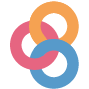)](https://mybinder.org/v2/gh/arviz-devs/arviz_sandbox/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Farviz-devs%252Fpreliz%26urlpath%3Dtree%252Fpreliz%252Fdocs%252Fexamples%252Fparam_space_1d_examples.ipynb%26branch%3Dmain)


:::{thebe-button}
:::

In [ ]:
# latest PreliZ might not be installed
import sys

!{sys.executable} -m pip install preliz@git+https://github.com/arviz-devs/preliz.git

In [1]:
import arviz as az
import preliz as pz

In [2]:
az.style.use("arviz-white")

(distributions_interactive)=

## Distributions

PreliZ is an open source project aiming to provide tools to help you define priors for your models. 

When setting priors for a Bayesian model, sometimes all we need is to quickly inspect the shape of a distribution. We usually what to identify were the bulk of the mass is, or how ticks the tails are. Even if we are familiar with a given family, getting the right parameters may require to change them a few times, until we get something close to what we have in mind.

With PreliZ we can easily plot the [probability density function](https://en.wikipedia.org/wiki/Probability_density_function) (pdf) of a given distribution.

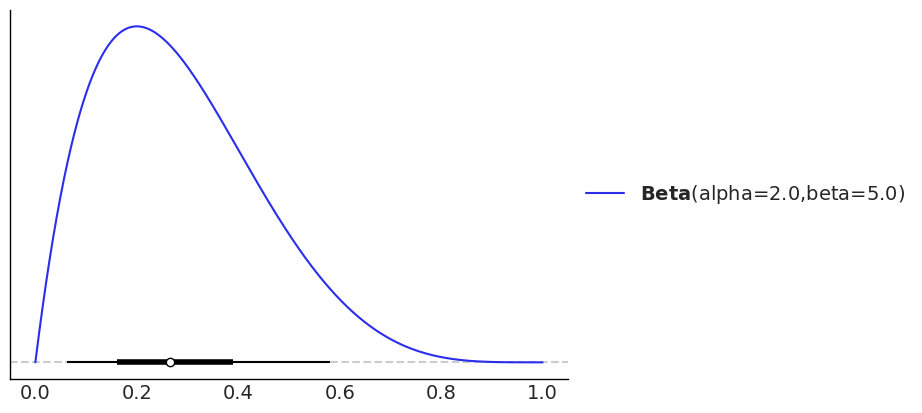

In [4]:
pz.Beta(2, 5).plot_pdf(pointinterval=True);

We got the PDF in blue, and because we passed the argument `pointinterval=True` we also got a box-plot-like element at the bottom, that may help us interpret what a `Beta(2, 5)` actually means. The white dot represents the median, the thicker line the interquartile range, i.e the interval defined by the quantiles 0.25 and 0.75 (or in other words the central 50% of the distribution) and the thinner line the interval defined by the 0.05 and 0.95 quantiles.

For simplicity we also use `plot_pdf` (instead of plot_pmf or something similar) for discrete distributions

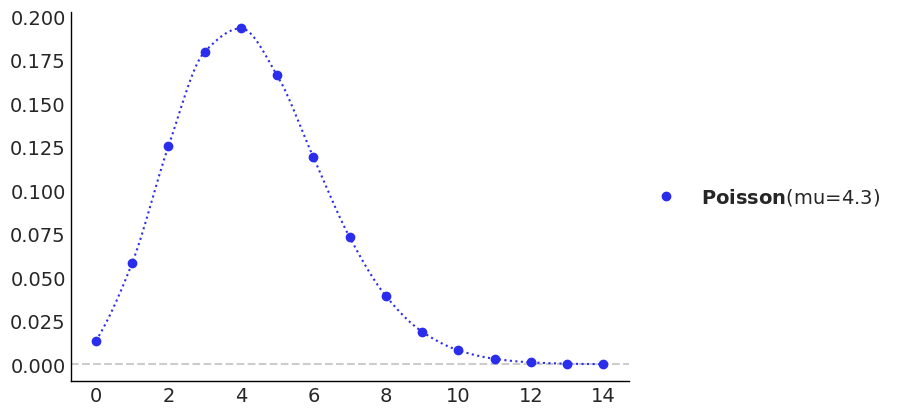

In [5]:
pz.Poisson(4.3).plot_pdf();

We can include more than one distribution in the same plot. This can be useful to compare the impact of parameters on a given distribution or maybe different distributions.

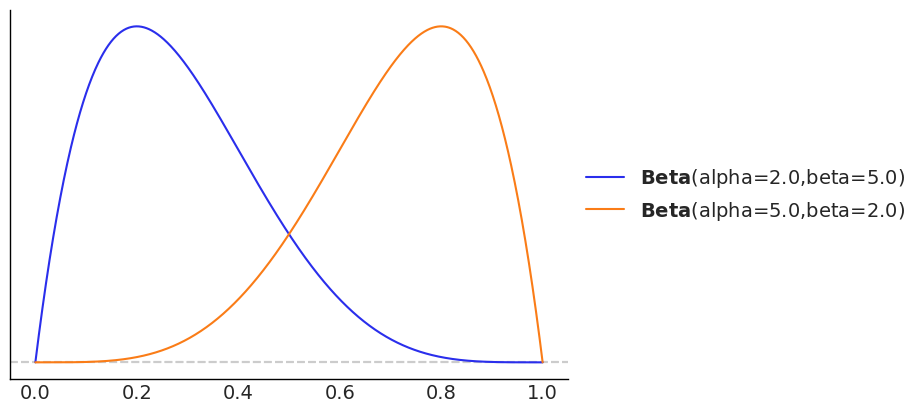

In [6]:
pz.Beta(2, 5).plot_pdf()
pz.Beta(5, 2).plot_pdf();

We can also easily plot the [cumulative distribution function](https://en.wikipedia.org/wiki/cumulative_distribution_function) (cdf).

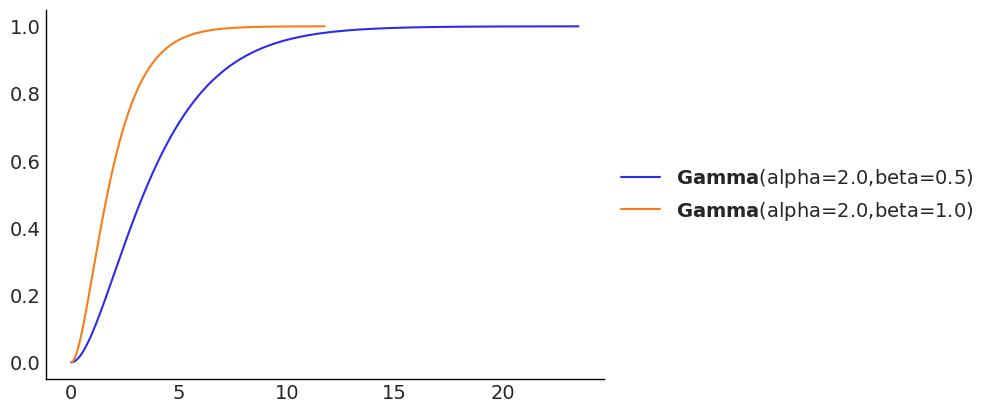

In [7]:
pz.Gamma(2, 0.5).plot_cdf()
pz.Gamma(2, 1).plot_cdf();

or the [quantile function](https://en.wikipedia.org/wiki/Quantile_function), also known as the percentile function or the inverse of the cdf.

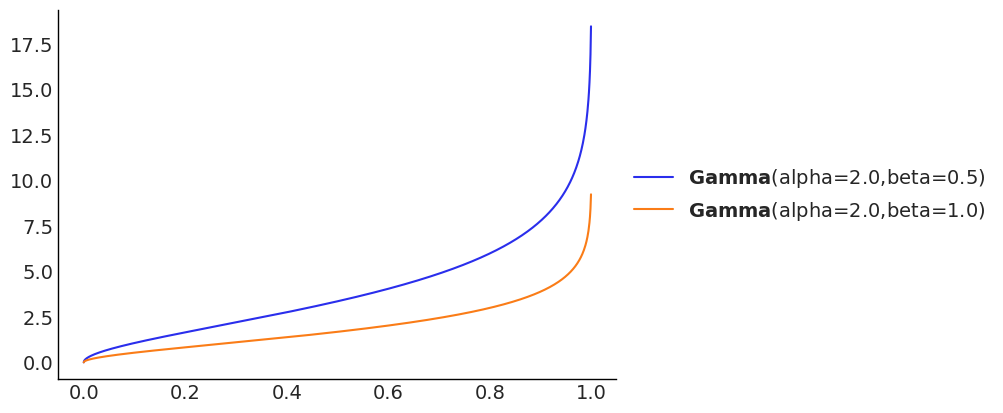

In [8]:
pz.Gamma(2, 0.5).plot_ppf()
pz.Gamma(2, 1).plot_ppf();

PreliZ also allows to interact with distributions using sliders.

In [14]:
pz.Gamma(mu=2, sigma=1).plot_interactive()

interactive(children=(FloatSlider(value=2.0, description='mu (0, inf)', max=12.0, min=2.220446049250313e-16, s…

As a general rule PreliZ distributions do not have default values for their parameters. Nevertheless, for the `plot_interactive()` method we made a exception and provide some default initialization, which can be handy if we are not very familiar with the parameters a distribution can take.

In [19]:
pz.Gamma().plot_interactive()

interactive(children=(FloatSlider(value=2.0, description='alpha (0, inf)', max=12.0, min=2.220446049250313e-16…

The slider will conform to the bounds of the parameters, for instance the `alpha` parameter of the Gamma distribution is restricted to be positive. So the slider for alpha will also be restricted to positive values. Because there is no upper bound, PreliZ will pick one for you, if you want to try with higher values of the parameter just initialize the distribution at higher values, like 

```python
pz.Gamma(alpha=50, beta=1).plot_interactive()
```

### Alternative parametrization

Some of the distributions in PreliZ can be defined in more that one way. For example, in the previous example we define Gamma in terms of `mu` and `alpha`, but we can also define this distribution in terms of `alpha` and `beta`.


### Properties of distributions

Once we have set the parameters of a distributions we can ask for properties of it. We can get a few summary statistics with the `summary` method.

In [20]:
dist = pz.Beta(2, 5)
dist.summary()

Beta(mean=0.29, median=0.26, std=0.16, lower=0.05, upper=0.63)

Additionally we can compute two different type of intervals out-of-the-box, the equal-tailed interval and the highest density interval. Following ArviZ, the default mass for both intervals is 0.94.

In [21]:
dist.eti(), dist.hdi()

((0.05, 0.63), (0.02, 0.57))

And we can get random samples

In [22]:
dist.rvs(10)

array([0.29477076, 0.17861228, 0.14426595, 0.10678593, 0.29840433,
       0.18620358, 0.33987031, 0.59629324, 0.33287769, 0.10664151])

or get the quantiles

In [24]:
dist.ppf([0.1, 0.5, 0.9])

array([0.09259526, 0.26444998, 0.51031631])

PreliZ distributions are wrappers of SciPy distributions, so once the parameters of a distribution are defined (i.e. the distribution has been frozen) we have access to the underlying `rv_frozen` object. For example, we can compute the logpdf by doing:

In [ ]:
dist.rv_frozen.logpdf(0.5)

(maxent_interactive)=

## From intervals to distributions

Sometimes the best route is not tweaking the parameters of a given distribution. Instead, we may want a distribution to satisfy certain contraints. For example we want to find a distribution that has certain mass inside some interval. PreliZ can do this with the `pz.maxent` function. This name of the function comes from "maximum entropy" as this function add one additional constraint, it returns the maximum entropy distribution.

Having priors with maximum entropy makes sense as this guarantees that we have the less informative distribution, given a set of constraints. In summary `pz.maxent` will find the distribution with maximum entropy that have a certain mass inside a given interval.

Here we compare a Beta and a Normal, with the constraints of having 0.6 of the probability mass inside the interval 0.3, 0.8.

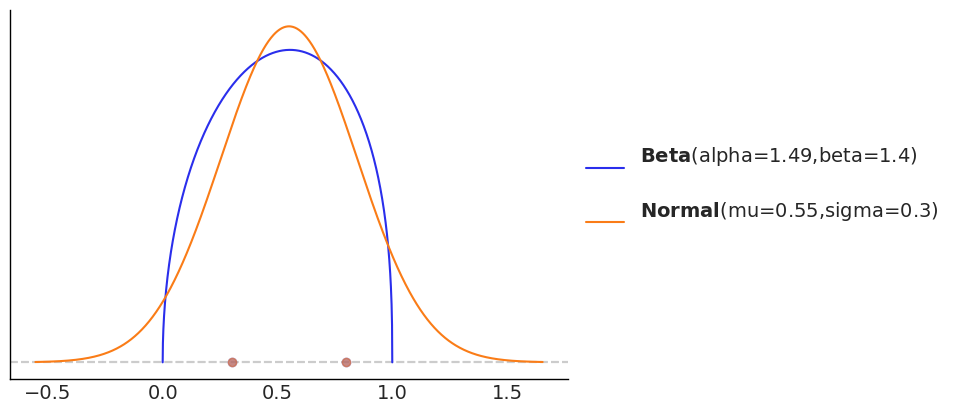

In [25]:
pz.maxent(pz.Beta(), 0.3, 0.8, 0.6)
pz.maxent(pz.Normal(), 0.3, 0.8, 0.6);

We can also keep some of the parameters fixed by directly passing their values to the distribution. For instance we may want to find a Gamma distribution with mean 4 and with 90% of the mass between 1 and 10.

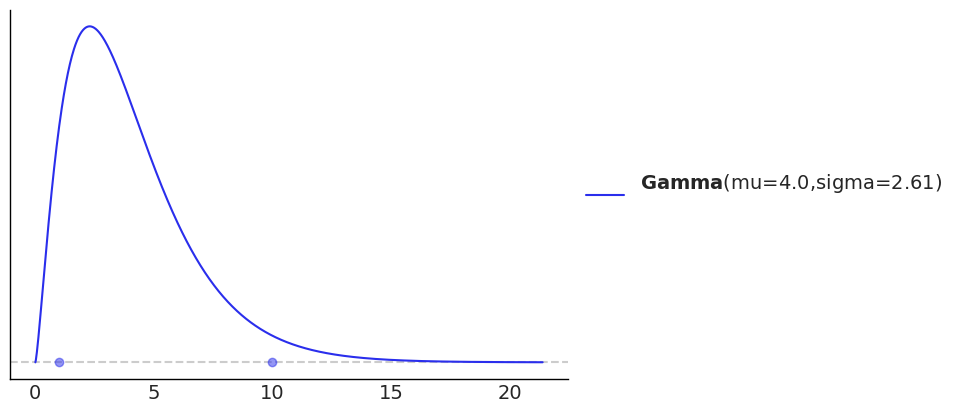

In [32]:
pz.maxent(pz.Gamma(mu=4), 1, 10, 0.9);

(quartile_interactive)=

## From intervals to distributions with quartiles

One alternative to `maxent` is to define a distribution by its [quartiles](https://en.wikipedia.org/wiki/Quartile), that is by the 3 points which divides the distribution into 4 parts each with 25% of the total mass.

The requested mass in the interval (q1=3 - q3=7) is 0.5, but the computed one is 0.48


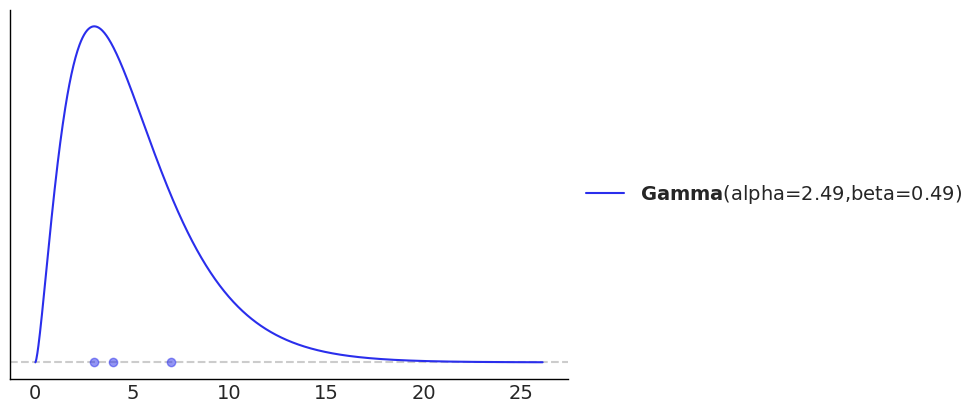

In [33]:
pz.quartile(pz.Gamma(), 3, 4, 7);

Both `pz.quartile` and `pz.maxent` will return a message when the difference between the requested and computed masses is larger than certain threshold.

(mle_interactive)=

## Maximum likelihood fit

Yet another scenario is to have some data that we want to use as a prior. One way to do it is to fit the data to some parametric family of distributions. We can then use a maximum likelihood estimate to get the distribution with the better fit.

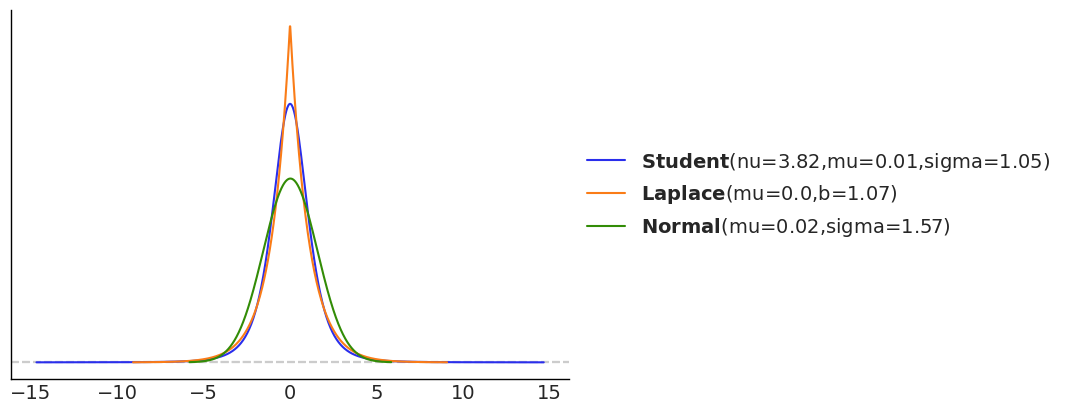

In [35]:
# In a real scenario this will be some data and not a sample from a Preliz distribution
sample = pz.Student(4, 0, 1).rvs(1000) 

dist0 = pz.Student()
dist1 = pz.Normal()
dist2 = pz.Laplace()
pz.mle([dist0, dist1, dist2], sample, plot=3);  # we ask to plot all 3 distribution

As expected the best match is provided by the Student-t distribution and the worst by the normal. By default `pz.mle` only plot the best match, but here we decided to get a plot of the 3 of them. Notice that distribution are updated in place so we can get access to them.

In [36]:
dist0

Student(nu=3.82,mu=0.01,sigma=1.05)

(roulette_interactive)=

## The roulette method

The roulette method allows to find prior distributions by *drawing*. The name roulette comes from the analogy that we are placing a limited set of chips where we thing the mass of a distribution should be.

For this task we are offered with a grid of m equally sized bins covering the range of x. And we have to allocate a total of n chips between the bins. In other words we use a grid to draw a histogram and the function will try to tell us what distribution, from a given pool of options, is a better fit for our drawing.

The `pz.roulette()` function uses matplotlib interactively, for this to work we need to we need call the magic `%matplotlib widget` and have ipywidgets installed (a requirement of PreliZ).

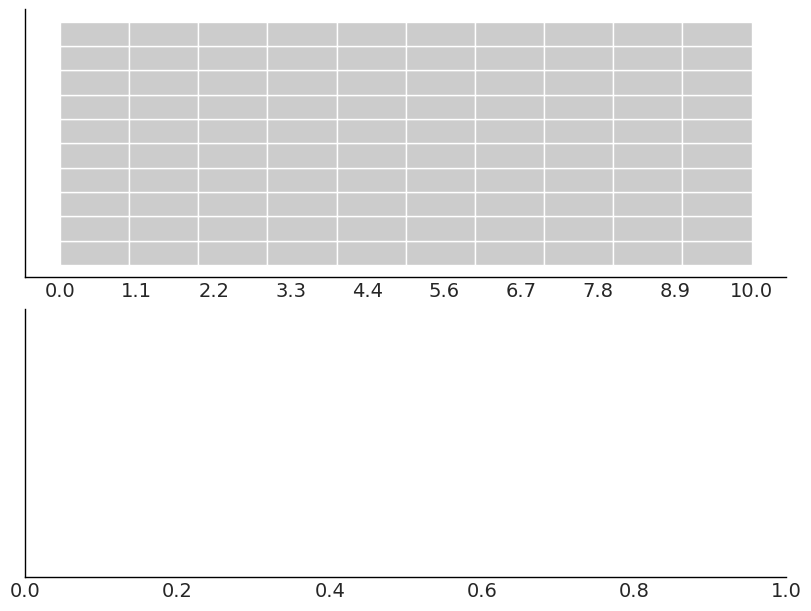

In [37]:
%matplotlib widget
pz.roulette()

If you are unable to run the previous cell, you can get a glimpse of `roulette` from this gif

![roulette](roulette.gif)